# Figure 6: Collocations plotted against altitude and T_LC

This notebook does not need the full dataset downloaded. This notebook can also be used to recreate Table 5 from the paper. 

In [58]:
from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from pycontrails.models.sac import T_critical_sac, T_sat_liquid_high_accuracy

from iagos_toolkit.weather.thermo import get_mixing_line_gradient_from_LHV, get_T_LM

In [59]:
df = pd.read_csv('../../data/landsat_sentinel_collocations_20260216.csv', comment='#')

In [60]:
df = df[df["air_temperature_iagos_validity"] <= 0]
df = df[df["rhl_iagos_validity"] <= 0]
df = df[df["contrail_formation"].notna()]
df = df[df["efficiency_PS_IAGOS"].notna()]
df = df[df["efficiency_PS_ERA5"].notna()]
# df = df[df["efficiency_BADA4_IAGOS"].notna()] # uncomment to create BADA4-only plot
# df = df[df["efficiency_BADA4_ERA5"].notna()]

print("Number of collocations:", len(df))

Number of collocations: 543


## Process the collocations and calculate the T_SAC and related uncertainties

In [61]:
def get_T_SAC(p: Union[float, np.ndarray],
              T: Union[float, np.ndarray],
              RH: Union[float, np.ndarray],
              **kwargs) -> np.ndarray:
    """
    Vectorized computation of T_SAC for given pressure, temperature, and RH.

    Parameters
    ----------
    p : float or np.ndarray
        Pressure in Pa
    T : float or np.ndarray
        Temperature in K
    RH : float or np.ndarray
        Relative humidity w.r.t water [0, 1]
    **kwargs :
        Additional parameters (e.g., eta)
    """
    # Ensure array form
    p = np.atleast_1d(p)
    T = np.atleast_1d(T)
    RH = np.atleast_1d(RH)

    # Broadcast arrays to same shape
    p, T, RH = np.broadcast_arrays(p, T, RH)

    # Vectorized computations
    G = get_mixing_line_gradient_from_LHV(p, **kwargs)
    T_LM = T_sat_liquid_high_accuracy(G)

    # Call T_critical_sac vectorized
    T_SAC = T_critical_sac(T_LM, RH, G, maxiter=10)

    return T_SAC

df["T_SAC_BADA4_IAGOS"] = get_T_SAC(
    df["air_pressure"].values,
    df["air_temperature_iagos"].values,
    df["rhl_iagos"].values,
    eta=df["efficiency_BADA4_IAGOS"].values
)

df["T_SAC_PS_IAGOS"] = get_T_SAC(
    df["air_pressure"].values,
    df["air_temperature_iagos"].values,
    df["rhl_iagos"].values,
    eta=df["efficiency_PS_IAGOS"].values
)

df["T_SAC_BADA4_ERA5"] = get_T_SAC(
    df["air_pressure"].values,
    df["air_temperature_era5"].values,
    df["rhl_era5"].values,
    eta=df["efficiency_BADA4_ERA5"].values
)

df["T_SAC_PS_ERA5"] = get_T_SAC(
    df["air_pressure"].values,
    df["air_temperature_era5"].values,
    df["rhl_era5"].values,
    eta=df["efficiency_PS_ERA5"].values
)

# For IAGOS
df["SAC_BADA4_IAGOS"] = df["air_temperature_iagos"] < df["T_SAC_BADA4_IAGOS"]
df["SAC_PS_IAGOS"]    = df["air_temperature_iagos"] < df["T_SAC_PS_IAGOS"]

# For ERA5
df["SAC_BADA4_ERA5"]  = df["air_temperature_era5"] < df["T_SAC_BADA4_ERA5"]
df["SAC_PS_ERA5"]     = df["air_temperature_era5"] < df["T_SAC_PS_ERA5"]

df["delta_T_SAC_PS_IAGOS"] = df["air_temperature_iagos"] - df["T_SAC_PS_IAGOS"]
df["delta_T_SAC_BADA4_IAGOS"] = df["air_temperature_iagos"] - df["T_SAC_BADA4_IAGOS"]
df["delta_T_SAC_PS_ERA5"] = df["air_temperature_era5"] - df["T_SAC_PS_ERA5"]
df["delta_T_SAC_BADA4_ERA5"] = df["air_temperature_era5"] - df["T_SAC_BADA4_ERA5"]

def classify_prediction(sac_value, true_label):
    if pd.isnull(sac_value):
        return None  # Skip if SAC is missing
    predicted = sac_value > 0 
    if predicted and true_label:
        return "TP"
    elif predicted and not true_label:
        return "FP"
    elif not predicted and not true_label:
        return "TN"
    elif not predicted and true_label:
        return "FN"

# Apply the logic to each row
df["result_BADA4_IAGOS"] = df.apply(
    lambda row: classify_prediction(row["SAC_BADA4_IAGOS"], row["contrail_formation"]), axis=1
)
df["result_PS_IAGOS"] = df.apply(
    lambda row: classify_prediction(row["SAC_PS_IAGOS"], row["contrail_formation"]), axis=1
)
df["result_BADA4_ERA5"] = df.apply(
    lambda row: classify_prediction(row["SAC_BADA4_ERA5"], row["contrail_formation"]), axis=1
)
df["result_PS_ERA5"] = df.apply(
    lambda row: classify_prediction(row["SAC_PS_ERA5"], row["contrail_formation"]), axis=1
)

In [62]:
def get_min_max_delta_t_sac(air_temperature, air_temperature_error, relative_humidity, relative_humidity_error, pressure, efficiency):
    # min_case
    air_temperature_min = air_temperature - air_temperature_error
    relative_humidity_max = relative_humidity + relative_humidity_error
    efficiency_max = efficiency * 1.15
    
    T_SAC_max = get_T_SAC(pressure,air_temperature_min, relative_humidity_max, eta=efficiency_max)
    delta_T_SAC_min = air_temperature_min - T_SAC_max

    # max_case
    air_temperature_max = air_temperature + air_temperature_error
    relative_humidity_min = relative_humidity - relative_humidity_error
    efficiency_min = efficiency / 1.15
    
    T_SAC_min = get_T_SAC(pressure, air_temperature_max, relative_humidity_min, eta=efficiency_min)
    delta_T_SAC_max = air_temperature_max - T_SAC_min

    return delta_T_SAC_min, delta_T_SAC_max

df[["delta_T_SAC_PS_IAGOS_min", "delta_T_SAC_PS_IAGOS_max"]] = df.apply(
    lambda row: get_min_max_delta_t_sac(
        row["air_temperature_iagos"], row["air_temperature_iagos_error"],
        row["rhl_iagos"], row["rhl_iagos_error"],
        row["air_pressure"],
        row["efficiency_PS_IAGOS"]
    ),
    axis=1,
    result_type="expand"
)

df[["delta_T_SAC_BADA4_IAGOS_min", "delta_T_SAC_BADA4_IAGOS_max"]] = df.apply(
    lambda row: get_min_max_delta_t_sac(
         row["air_temperature_iagos"], row["air_temperature_iagos_error"],
        row["rhl_iagos"], row["rhl_iagos_error"],
        row["air_pressure"],
        row["efficiency_BADA4_IAGOS"]
    ),
    axis=1,
    result_type="expand"
)

## Present results in table format (Table 5)

In [63]:
df["crosses_zero"] = (
    (df["delta_T_SAC_PS_IAGOS_min"] < 0) &
    (df["delta_T_SAC_PS_IAGOS_max"] > 0)
)

df["result_PS_IAGOS_unc"] = df["result_PS_IAGOS"]

mask = df["crosses_zero"]

df.loc[mask & (df["result_PS_IAGOS"] == "FP"), "result_PS_IAGOS_unc"] = "TN"
df.loc[mask & (df["result_PS_IAGOS"] == "FN"), "result_PS_IAGOS_unc"] = "TP"

met_map = {
    "IAGOS": "result_PS_IAGOS",
    "IAGOS (within uncertainty)": "result_PS_IAGOS_unc",
    "ERA5": "result_PS_ERA5",
}

metrics = []

for sat, group in df.groupby("satellite"):
    for met, col in met_map.items():

        tp = (group[col] == "TP").sum()
        fp = (group[col] == "FP").sum()
        fn = (group[col] == "FN").sum()
        tn = (group[col] == "TN").sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else float("nan")
        recall = tp / (tp + fn) if (tp + fn) > 0 else float("nan")

        N = tp + fp + fn + tn
        random_hits = ((tp + fp) * (tp + fn)) / N if N > 0 else 0
        ets = (
            (tp - random_hits) /
            (tp + fp + fn - random_hits)
            if (tp + fp + fn - random_hits) != 0
            else float("nan")
        )

        metrics.append({
            "Satellite": sat,
            "Met": met,
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "TN": tn,
            "precision": precision,
            "recall": recall,
            "ETS": ets,
            "count": len(group),
        })

metrics_df = pd.DataFrame(metrics)
metrics_df.sort_values(by=["Satellite", "Met"], inplace=True)

cols = ["Satellite", "Met", "TP", "FP", "FN", "TN",
        "precision", "recall"]

print("Poll-Schumann: \n")
print(" & ".join(cols) + " \\\\")
for _, row in metrics_df[cols].iterrows():
    
    line = " & ".join(
        f"{val:.3f}" if isinstance(val, float) else str(val)
        for val in row
    )
    print(line + " \\\\")

Poll-Schumann: 

Satellite & Met & TP & FP & FN & TN & precision & recall \\
Landsat & ERA5 & 80 & 15 & 2 & 80 & 0.842 & 0.976 \\
Landsat & IAGOS & 78 & 11 & 4 & 84 & 0.876 & 0.951 \\
Landsat & IAGOS (within uncertainty) & 81 & 5 & 1 & 90 & 0.942 & 0.988 \\
Sentinel & ERA5 & 192 & 23 & 3 & 148 & 0.893 & 0.985 \\
Sentinel & IAGOS & 192 & 8 & 3 & 163 & 0.960 & 0.985 \\
Sentinel & IAGOS (within uncertainty) & 194 & 2 & 1 & 169 & 0.990 & 0.995 \\


## Same results for PS, but then with accuracy as well

In [64]:
# metrics = []

# for sat, group in df.groupby("satellite"):
#     for met, col in met_map.items():

#         tp = (group[col] == "TP").sum()
#         fp = (group[col] == "FP").sum()
#         fn = (group[col] == "FN").sum()
#         tn = (group[col] == "TN").sum()

#         precision = tp / (tp + fp) if (tp + fp) > 0 else float("nan")
#         recall = tp / (tp + fn) if (tp + fn) > 0 else float("nan")

#         N = tp + fp + fn + tn
#         random_hits = ((tp + fp) * (tp + fn)) / N if N > 0 else 0
#         ets = (
#             (tp - random_hits) /
#             (tp + fp + fn - random_hits)
#             if (tp + fp + fn - random_hits) != 0
#             else float("nan")
#         )
        
#         accuracy = (tp + tn) / N if N > 0 else float("nan")  # <--- new

#         metrics.append({
#             "Satellite": sat,
#             "Met": met,
#             "TP": tp,
#             "FP": fp,
#             "FN": fn,
#             "TN": tn,
#             "precision": precision,
#             "recall": recall,
#             "ETS": ets,
#             "accuracy": accuracy,  # <--- add here
#             "count": len(group),
#         })

# metrics_df = pd.DataFrame(metrics)
# metrics_df.sort_values(by=["Satellite", "Met"], inplace=True)
# metrics_df

## Combined results for Landsat and Sentinel

In [65]:
# combined = (
#     metrics_df[metrics_df["Satellite"].isin(["Landsat", "Sentinel"])]
#     .groupby("Met")
#     .agg({
#         "TP": "sum",
#         "FP": "sum",
#         "FN": "sum",
#         "TN": "sum",
#         "count": "sum"
#     })
#     .reset_index()
# )

# # Recompute metrics
# combined["precision"] = combined["TP"] / (combined["TP"] + combined["FP"])
# combined["recall"] = combined["TP"] / (combined["TP"] + combined["FN"])
# N = combined["TP"] + combined["FP"] + combined["FN"] + combined["TN"]
# random_hits = ((combined["TP"] + combined["FP"]) * (combined["TP"] + combined["FN"])) / N
# combined["ETS"] = (combined["TP"] - random_hits) / (combined["TP"] + combined["FP"] + combined["FN"] - random_hits)
# combined["accuracy"] = (combined["TP"] + combined["TN"]) / N
# combined["Satellite"] = "Landsat+Sentinel"  # label
# combined

## Results for BADA 4.2, for Table A3 in appendix

In [66]:
# df["crosses_zero"] = (
#     (df["delta_T_SAC_BADA4_IAGOS_min"] < 0) &
#     (df["delta_T_SAC_BADA4_IAGOS_max"] > 0)
# )

# df["result_BADA4_IAGOS_unc"] = df["result_BADA4_IAGOS"]

# mask = df["crosses_zero"]

# df.loc[mask & (df["result_BADA4_IAGOS"] == "FP"), "result_BADA4_IAGOS_unc"] = "TN"
# df.loc[mask & (df["result_BADA4_IAGOS"] == "FN"), "result_BADA4_IAGOS_unc"] = "TP"

# met_map = {
#     "IAGOS": "result_BADA4_IAGOS",
#     "IAGOS (within uncertainty)": "result_BADA4_IAGOS_unc",
#     "ERA5": "result_BADA4_ERA5",
# }

# metrics = []

# for sat, group in df.groupby("satellite"):
#     for met, col in met_map.items():

#         tp = (group[col] == "TP").sum()
#         fp = (group[col] == "FP").sum()
#         fn = (group[col] == "FN").sum()
#         tn = (group[col] == "TN").sum()

#         precision = tp / (tp + fp) if (tp + fp) > 0 else float("nan")
#         recall = tp / (tp + fn) if (tp + fn) > 0 else float("nan")

#         N = tp + fp + fn + tn
#         random_hits = ((tp + fp) * (tp + fn)) / N if N > 0 else 0
#         ets = (
#             (tp - random_hits) /
#             (tp + fp + fn - random_hits)
#             if (tp + fp + fn - random_hits) != 0
#             else float("nan")
#         )

#         metrics.append({
#             "Satellite": sat,
#             "Met": met,
#             "TP": tp,
#             "FP": fp,
#             "FN": fn,
#             "TN": tn,
#             "precision": precision,
#             "recall": recall,
#             "ETS": ets,
#             "count": len(group),
#         })

# metrics_df = pd.DataFrame(metrics)
# metrics_df.sort_values(by=["Satellite", "Met"], inplace=True)

# cols = ["Satellite", "Met", "TP", "FP", "FN", "TN",
#         "precision", "recall"]

# print("BADA: \n")
# print(" & ".join(cols) + " \\\\")
# for _, row in metrics_df[cols].iterrows():
    
#     line = " & ".join(
#         f"{val:.3f}" if isinstance(val, float) else str(val)
#         for val in row
#     )
#     print(line + " \\\\")


## Figure plotting

/var/folders/zt/t69lkpcs0mz7l5vz3jt_48ldzb8s6f/T/ipykernel_75442/1181890169.py:101: UserWarning: You passed a edgecolor/edgecolors ('#E66100') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_inset.scatter(
/var/folders/zt/t69lkpcs0mz7l5vz3jt_48ldzb8s6f/T/ipykernel_75442/1181890169.py:101: UserWarning: You passed a edgecolor/edgecolors ('purple') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_inset.scatter(


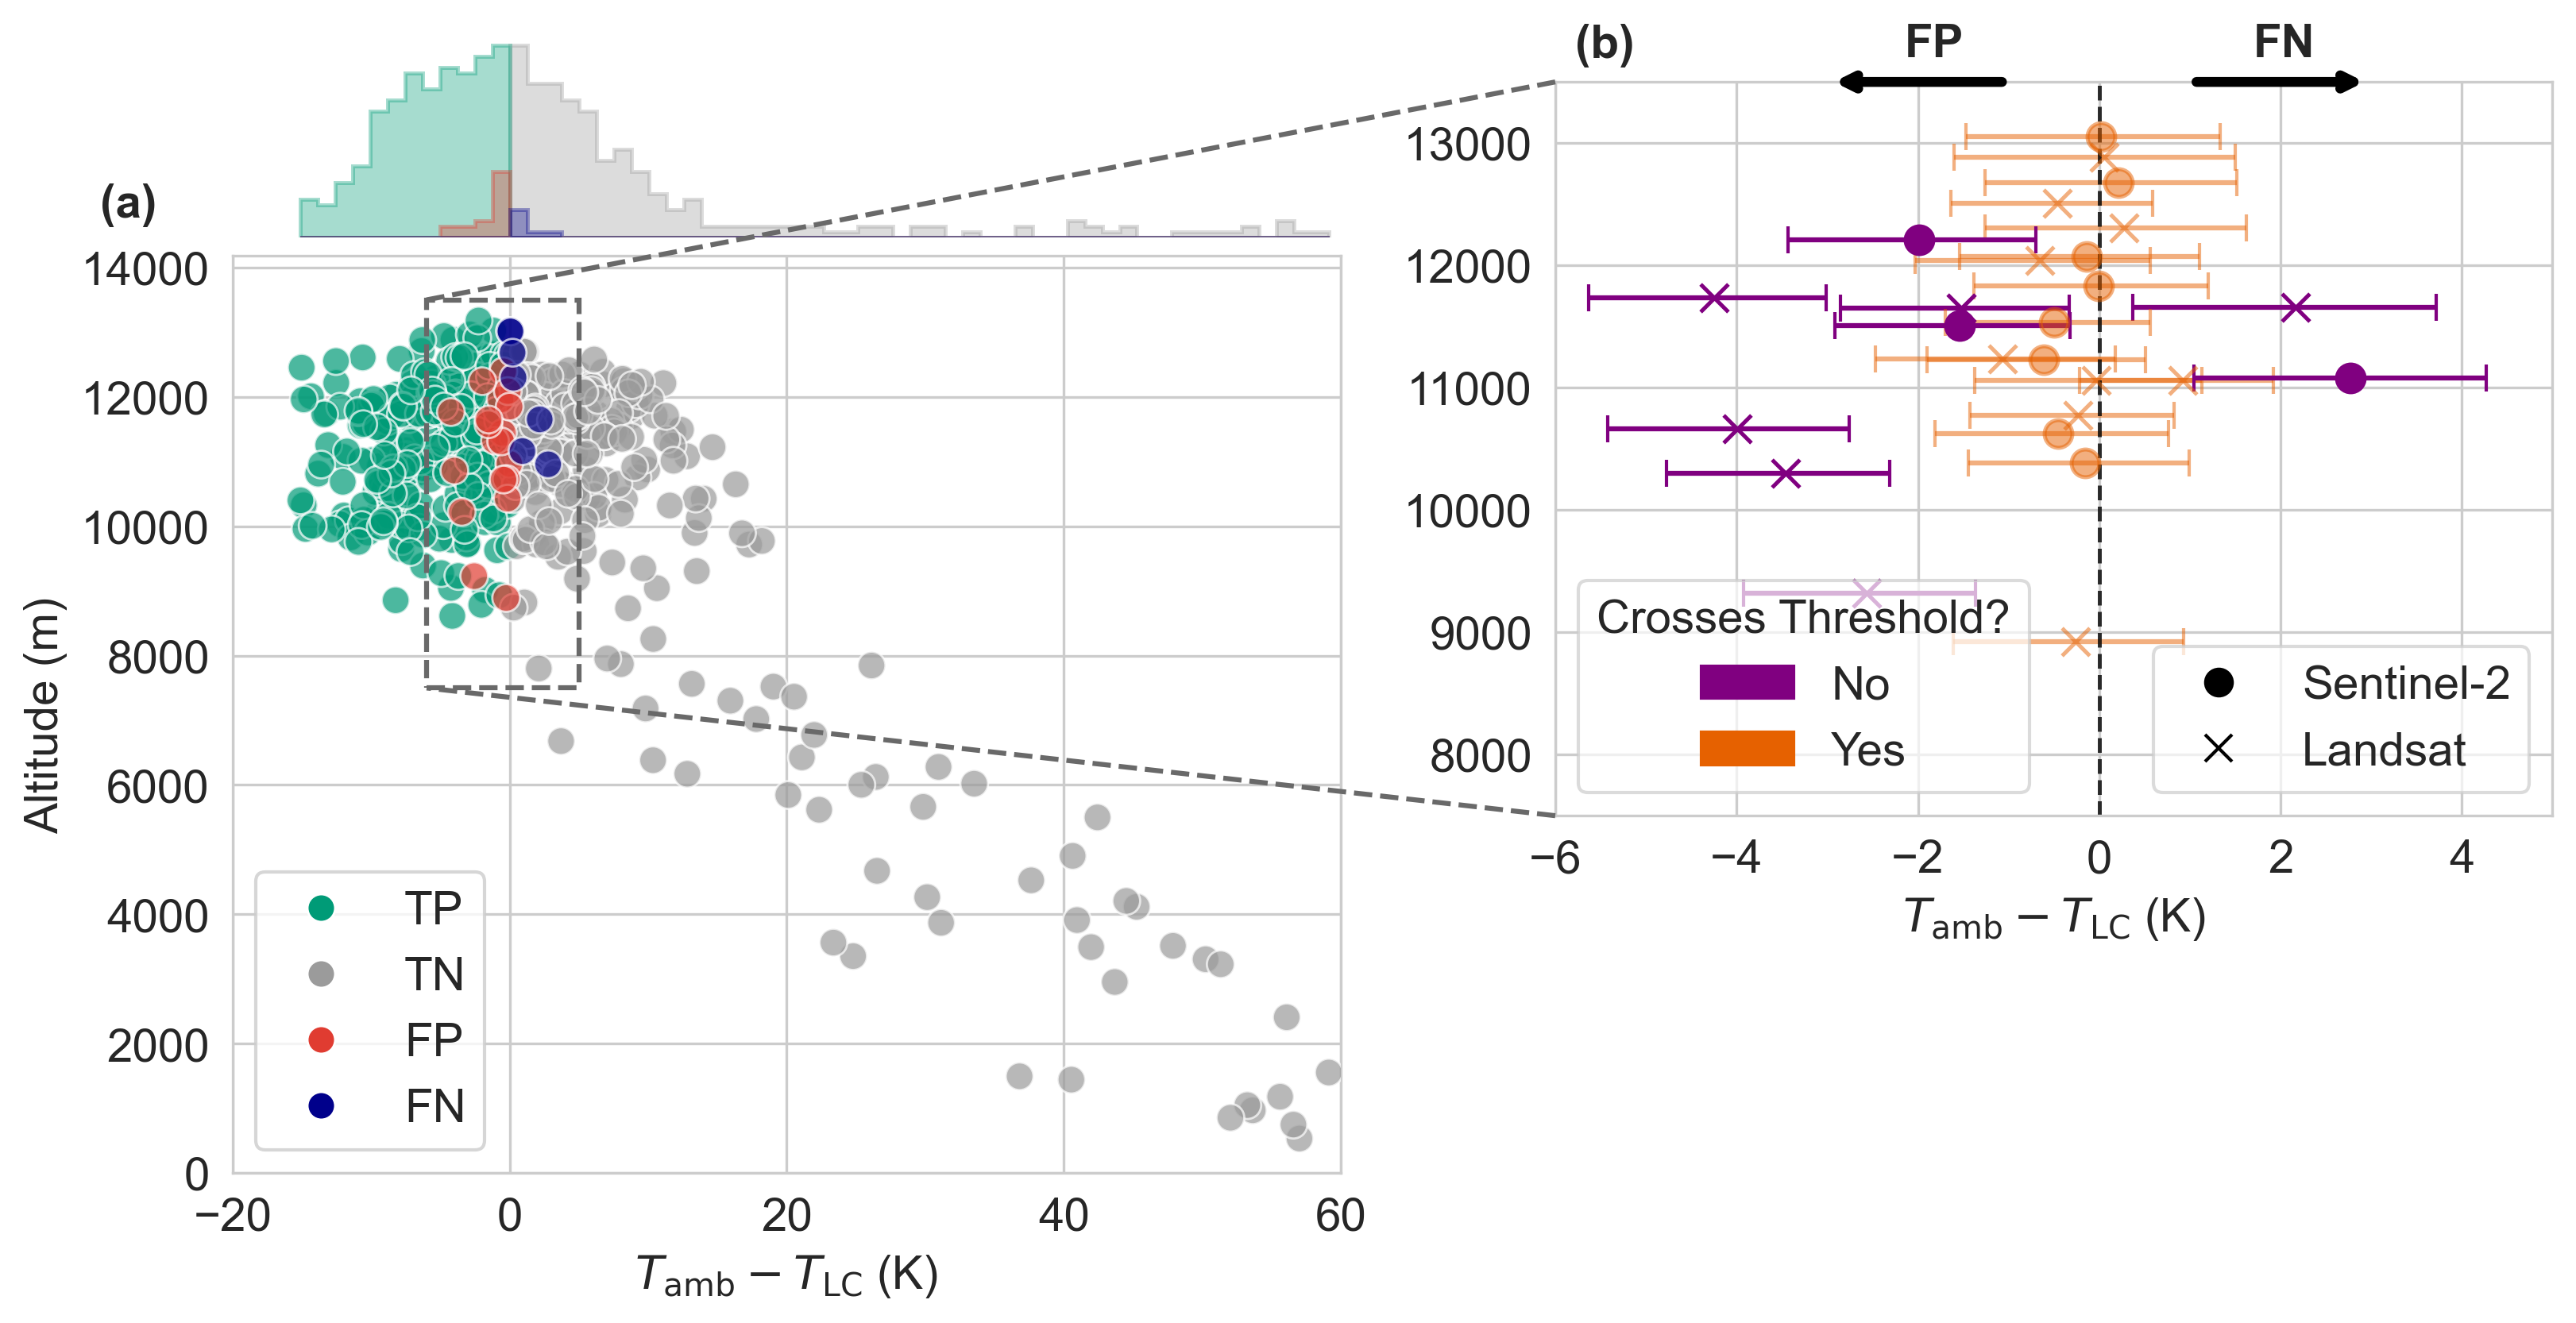

In [67]:
sns.set_style("whitegrid")

plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14
})

# Palettes and mappings
palette_all = {"TN": "#9b9b9b", "TP": "#009b77", "FP": "#e03c31", "FN": "darkblue"}

satellite_marker_style = {
    "Sentinel": dict(marker="o", filled=True),
    "Landsat":  dict(marker="x", filled=True),
}

# Figure
fig = plt.figure(figsize=(6, 5), dpi=300)
ax_main = fig.add_subplot(111)

order = {"TP": 0, "TN": 1, "FP": 2, "FN": 3}
df_sorted = df.copy()
df_sorted["plot_order"] = df_sorted["result_PS_IAGOS"].map(order)
df_sorted = df_sorted.sort_values("plot_order")

# Main scatter
sns.scatterplot(
    data=df_sorted,
    x="delta_T_SAC_PS_IAGOS",
    y="altitude",
    hue="result_PS_IAGOS",
    hue_order=["TP", "TN", "FP", "FN"],
    palette=palette_all,
    marker="o",
    alpha=0.7,
    s=70,
    ax=ax_main,
    zorder=3
)


ax_main.set_xlabel(r"$T_{\mathrm{amb}} - T_{\mathrm{LC}}$ (K)")
ax_main.set_ylabel("Altitude (m)")
ax_main.set_xlim(-20, 60)
ax_main.set_ylim(0, df["altitude"].max() + 1000)
legend = ax_main.legend(loc="lower left")

# Make legend markers fully opaque
for handle in legend.legend_handles:
    handle.set_alpha(1)

# Top KDE
ax_top = ax_main.inset_axes([0, 1.02, 1, 0.22], sharex=ax_main)
bins = np.linspace(
    df["delta_T_SAC_PS_IAGOS"].min(),
    df["delta_T_SAC_PS_IAGOS"].max(),
    60
)

for category, color in palette_all.items():
    subset = df[df["result_PS_IAGOS"] == category]
    ax_top.hist(
        subset["delta_T_SAC_PS_IAGOS"],
        bins=bins,
        density=False,        # comparable across categories
        histtype="stepfilled",
        alpha=0.35,
        color=color,
        edgecolor=color,
        linewidth=1.2
    )

ax_top.axis("off")

# FP/FN inset (same size as main, placed to the right)
bbox = ax_main.get_position()
ax_inset = fig.add_axes([
    bbox.x1 + 0.15,
    bbox.y0 + 0.3,
    bbox.width * 0.9,
    bbox.height * 0.8
])

subset = df[df["result_PS_IAGOS"].isin(["FP", "FN"])].copy()
rng = np.random.default_rng(42)
subset["altitude_jittered"] = subset["altitude"] + rng.normal(0, 100, size=len(subset))
subset["crosses_zero"] = (
    (subset["delta_T_SAC_PS_IAGOS_min"] < 0) &
    (subset["delta_T_SAC_PS_IAGOS_max"] > 0)
)

# Scatter with satellite markers
for _, row in subset.iterrows():
    style = satellite_marker_style[row["satellite"]]
    color = palette_all[row["result_PS_IAGOS"]]
    alpha_val = 0.5 if row["crosses_zero"] else 1.0
    color = "purple" if not row["crosses_zero"] else "#E66100"

    ax_inset.scatter(
        row["delta_T_SAC_PS_IAGOS"],
        row["altitude_jittered"],
        marker=style["marker"],
        s=70,
        facecolors=color if style["filled"] else "none",
        edgecolors=color,
        linewidths=1.2,
        alpha=alpha_val,
        zorder=3
    )

# Error bars
for _, row in subset.iterrows():
    color = palette_all[row["result_PS_IAGOS"]]
    xerr = np.array([
        row["delta_T_SAC_PS_IAGOS"] - row["delta_T_SAC_PS_IAGOS_min"],
        row["delta_T_SAC_PS_IAGOS_max"] - row["delta_T_SAC_PS_IAGOS"]
    ])
    alpha_val = 0.5 if row["crosses_zero"] else 1.0
    color = "purple" if not row["crosses_zero"] else "#E66100"
    ax_inset.errorbar(
        row["delta_T_SAC_PS_IAGOS"],
        row["altitude_jittered"],
        xerr=xerr.reshape(2, 1),
        fmt="none",
        ecolor=color,
        elinewidth=1.5,
        capsize=4,
        alpha=alpha_val,
        zorder=2
    )

ax_inset.axvline(0, color="black", linestyle="--", linewidth=1.2, alpha=0.8)
ax_inset.set_xlim(-6, 5)
ax_inset.set_ylim(7500, 13500)
ax_inset.set_xlabel(r"$T_{\mathrm{amb}} - T_{\mathrm{LC}}$ (K)")
ax_inset.axis("on")

# Create legend handles for satellites
sat_handles = [
    Line2D([0], [0], marker="o", linestyle="", color="black",
           markerfacecolor="black", markersize=8, label="Sentinel-2"),
    Line2D([0], [0], marker="x", linestyle="", color="black",
           markerfacecolor="black", markersize=8, label="Landsat")
]

sat_legend = ax_inset.legend(
    handles=sat_handles,
    loc="lower right",
    fontsize=14,
    title_fontsize=14,
    framealpha=0.7
)

ax_inset.add_artist(sat_legend)

contrail_handles = [
    Patch(
        facecolor="purple",
        edgecolor="purple",
        label="No"
    ),
    Patch(
        facecolor="#E66100",
        edgecolor="#E66100",
        label="Yes"
    ),
]

ax_inset.legend(
    handles=contrail_handles,
    title="Crosses Threshold?",
    loc="lower left",
    fontsize=14,
    title_fontsize=14,
    framealpha=0.7
)


# Mark inset linkage
mark_inset(
    ax_main,
    ax_inset,
    loc1=2,
    loc2=3,
    fc="none",
    ec="dimgrey",
    linestyle="--",
    lw=1.5,
    zorder=17
)

ax_main.text(
    -0.12, 1.08, "(a)",
    transform=ax_main.transAxes,
    fontsize=14,
    fontweight="bold",
    va="top"
)
ax_inset.text(
    0.02, 1.08, "(b)",
    transform=ax_inset.transAxes,
    fontsize=14,
    fontweight="bold",
    va="top",
    ha="left"
)

ax_inset.grid(True)
ax_main.grid(True)

ax_inset.text(
    0.35, 1.08, "FP",
    transform=ax_inset.transAxes,
    fontsize=14,
    fontweight="bold",
    va="top",
    ha="left"
)

ax_inset.text(
    0.70, 1.08, "FN",
    transform=ax_inset.transAxes,
    fontsize=14,
    fontweight="bold",
    va="top",
    ha="left"
)

arrow_props = dict(arrowstyle="->", color="black", lw=3)

# FN arrow
ax_inset.annotate(
    "",
    xy=(3, 13500),
    xytext=(1, 13500),
    ha="center",
    va="center",
    color="black",
    fontweight="bold",
    arrowprops=arrow_props,
    clip_on=False
)

# FP arrow
ax_inset.annotate(
    "",
    xy=(-3, 13500),
    xytext=(-1, 13500),
    ha="center",
    va="center",
    color="black",
    fontweight="bold",
    arrowprops=arrow_props,
    clip_on=False
)

plt.savefig("figures/fig06.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Statistics on altitude, vertical rate, and temperature of false predictions

In [68]:
print(subset["altitude"].min())
print(subset["altitude"].max())
print(subset["altitude"].mean())

8891.012277
13018.701375
11401.52362426731


In [69]:
print("Number of false predictions during climb:", subset[subset["vertical_rate"] > 100].shape[0])
print("Number of false predictions during cruise:", subset[abs(subset["vertical_rate"]) < 100].shape[0])
print("Number of false predictions during descent:", subset[subset["vertical_rate"] < -100].shape[0])

Number of false predictions during climb: 3
Number of false predictions during cruise: 23
Number of false predictions during descent: 0


In [70]:
subset_FP = subset[subset["result_PS_IAGOS"] == "FP"]
print("(FP) Min air temperature: ", subset_FP["air_temperature_iagos"].min())
print("(FP) Max air temperature: ", subset_FP["air_temperature_iagos"].max())
print("(FP) Mean air temperature: ", subset_FP["air_temperature_iagos"].mean())

subset_FN = subset[subset["result_PS_IAGOS"] == "FN"]
print("(FN) Min air temperature: ", subset_FN["air_temperature_iagos"].min())
print("(FN) Max air temperature: ", subset_FN["air_temperature_iagos"].max())
print("(FN) Mean air temperature: ", subset_FN["air_temperature_iagos"].mean())

(FP) Min air temperature:  217.05166303524015
(FP) Max air temperature:  224.63659927841184
(FP) Mean air temperature:  220.49309423381928
(FN) Min air temperature:  220.4600067138672
(FN) Max air temperature:  228.6626655845642
(FN) Mean air temperature:  223.36237081253051


In [71]:
subset_FP = subset[subset["result_PS_IAGOS"] == "FP"]
print("(FP) Min relative humidity w.r.t. ice: ", subset_FP["rhi_iagos"].min() * 100)
print("(FP) Max relative humidity w.r.t. ice: ", subset_FP["rhi_iagos"].max() * 100)
print("(FP) Mean relative humidity w.r.t. ice: ", subset_FP["rhi_iagos"].mean() * 100)

subset_FN = subset[subset["result_PS_IAGOS"] == "FN"]
print("(FN) Min relative humidity w.r.t. ice: ", subset_FN["rhi_iagos"].min() * 100)
print("(FN) Max relative humidity w.r.t. ice: ", subset_FN["rhi_iagos"].max() * 100)
print("(FN) Mean relative humidity w.r.t. ice: ", subset_FN["rhi_iagos"].mean() * 100)

(FP) Min relative humidity w.r.t. ice:  4.80609048344194
(FP) Max relative humidity w.r.t. ice:  66.17449956560135
(FP) Mean relative humidity w.r.t. ice:  22.662226189186487
(FN) Min relative humidity w.r.t. ice:  5.449670786508539
(FN) Max relative humidity w.r.t. ice:  109.27510021030903
(FN) Mean relative humidity w.r.t. ice:  60.63629485818824
